In [34]:
pip install opencv-python moviepy openai-whisper torch torchvision transformers xgboost imbalanced-learn matplotlib seaborn pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


## Importação das bibliotecas

In [35]:
import os
import cv2
import whisper
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import clip
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import pearsonr, spearmanr

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from transformers import AutoTokenizer, AutoModel

# Configurações
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VIDEO_DIR = "data/Dataset/videos"
DATASET_PATH = "data/dataset_final.csv"

## Avisos

In [26]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="whisper.transcribe")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
os.environ["TOKENIZERS_PARALLELISM"] = "false"


## Processamento de Vídeo

In [27]:
def extract_frames(video_path, frame_rate=1):
    """Extrai frames de um vídeo usando OpenCV"""
    cap = cv2.VideoCapture(video_path)
    frames = []
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if len(frames) % frame_interval == 0:
            frames.append(frame)
    cap.release()
    return frames

def transcribe_audio(video_path):
    """Transcreve áudio com Whisper"""
    model = whisper.load_model("base", device=DEVICE)
    result = model.transcribe(video_path)
    return result["text"]

## Extração de Embeddings

In [28]:
def get_visual_embeddings(frames):
    """Gera embeddings visuais com CLIP e projeta para o espaço de 768 dimensões"""
    model, preprocess = clip.load("ViT-B/32", device=DEVICE)
    embeddings = []
    
    for frame in frames:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        image_tensor = preprocess(pil_image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            embedding = model.encode_image(image_tensor)
            embeddings.append(embedding.cpu().numpy().squeeze())
    
    # Média dos embeddings dos frames
    visual_embedding = np.mean(embeddings, axis=0)
    
    # Projeção para 768 dimensões
    projection_layer = nn.Linear(512, 768)
    visual_embedding = torch.tensor(visual_embedding).unsqueeze(0).to(DEVICE)
    visual_embedding = projection_layer(visual_embedding).squeeze()
    
    # Desanexa o tensor e move para a CPU antes de converter para NumPy
    visual_embedding_np = visual_embedding.detach().cpu().numpy()
    
    return visual_embedding_np



def get_text_embeddings_bert(text, model_name='neuralmind/bert-base-portuguese-cased'):
    """Gera embeddings textuais com BERT"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    inputs = tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=512
    )
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [29]:
videos = []

# Adiciona vídeos de 1 a 40 com target 1
for i in range(1, 41):
    videos.append((f"Video{i}.mp4", 1))

# Adiciona vídeos de 41 a 51 com target 0
for i in range(41, 52):
    videos.append((f"Video{i}.mp4", 0))

# Cria DataFrame
df = pd.DataFrame(videos, columns=["video_path", "target"])

# Salva o CSV
df.to_csv("data/Dataset/metadata.csv", index=False)

## Carregamento de metadados com target e Modelo Xgboost

In [30]:
# Carrega metadados (rótulos manuais)
metadata = pd.read_csv("data/Dataset/metadata.csv")  # Arquivo com colunas: [video_path, target]

# Processa cada vídeo
all_data = []

for idx, row in metadata.iterrows():
    video_path = os.path.join(VIDEO_DIR, row["video_path"])
    
    # Processamento de vídeo
    frames = extract_frames(video_path)
    visual_embedding = get_visual_embeddings(frames)
    
    # Processamento de áudio
    transcription = transcribe_audio(video_path)
    text_embedding = get_text_embeddings_bert(transcription)
    
    # Combina embeddings
    combined = np.concatenate([visual_embedding, text_embedding])
    all_data.append({
        "features": combined,
        "target": row["target"]
    })

    print("Em processamento")

# Cria DataFrame final
df = pd.DataFrame(all_data)

# Duplica dados com target 0
false_samples = df[df['target'] == 0]
df = pd.concat([df, false_samples.sample(5, replace=True)])

X = np.vstack(df["features"])
y = df["target"]

# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Treino-Teste Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)

# Treina XGBoost
model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.01
)
model.fit(X_train, y_train)

# Avaliação
y_pred = model.predict(X_test)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

# Ajuste de Threshold (Opcional)
y_probs = model.predict_proba(X_test)[:, 1]
optimal_threshold = 0.4  # Definir via curva ROC
y_pred_adj = (y_probs > optimal_threshold).astype(int)

Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Em processamento
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      

Média de Correlação de Pearson: 0.881917103688197
Média de Correlação de Spearman: 0.881917103688197
Média da Distância do Cosseno: 0.5561679005622864


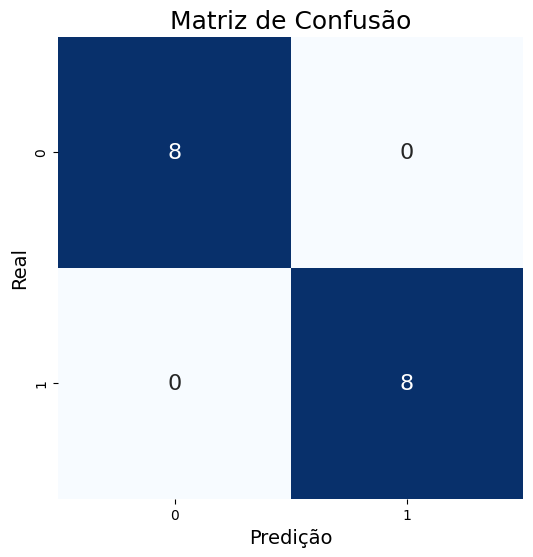

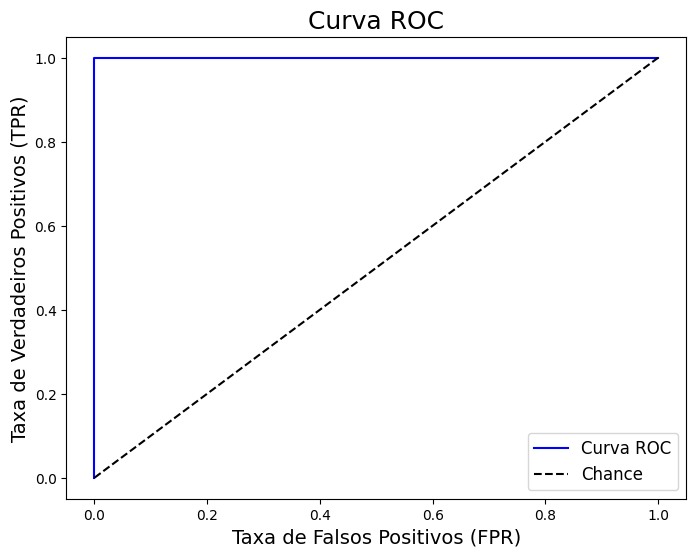

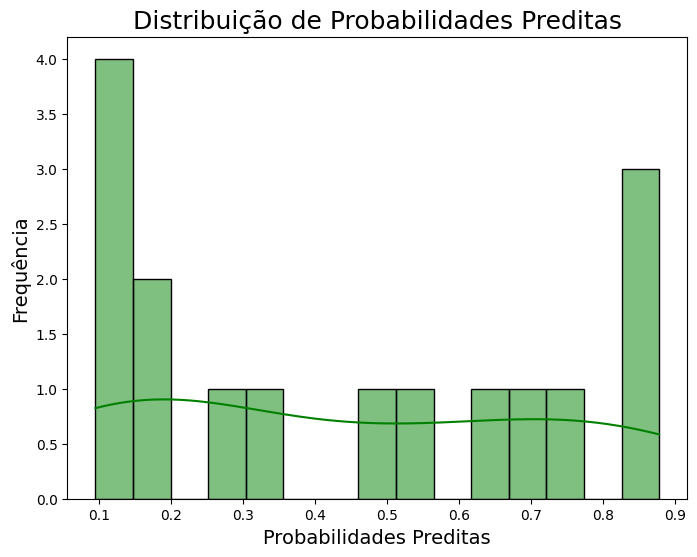

In [36]:
pearson_corr, _ = pearsonr(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

# Distância do Cosseno
cos_dist = cosine_distances(X_test)

print(f"Média de Correlação de Pearson: {pearson_corr}")
print(f"Média de Correlação de Spearman: {spearman_corr}")
print(f"Média da Distância do Cosseno: {np.mean(cos_dist)}")

# Visualizações
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
    plt.title("Matriz de Confusão", fontsize=18)
    plt.xlabel("Predição", fontsize=14)
    plt.ylabel("Real", fontsize=14)
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label='Curva ROC')
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', label='Chance')
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=14)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=14)
    plt.title('Curva ROC', fontsize=18)
    plt.legend(loc='lower right', fontsize=12)
    plt.show()

def plot_predicted_probabilities(y_probs):
    plt.figure(figsize=(8, 6))
    sns.histplot(y_probs, kde=True, color="green", bins=15)
    plt.title("Distribuição de Probabilidades Preditas", fontsize=18)
    plt.xlabel('Probabilidades Preditas', fontsize=14)
    plt.ylabel('Frequência', fontsize=14)
    plt.show()

# Plot de gráficos
plot_confusion_matrix(y_test, y_pred_adj)
plot_roc_curve(y_test, y_probs)
plot_predicted_probabilities(y_probs)


In [37]:
import joblib

# Salvar o modelo treinado
joblib.dump(model, 'xgboost_model.pkl')


['xgboost_model.pkl']

In [ ]:
def carregar_modelo(model_path='xgboost_model.pkl'):
    return joblib.load(model_path)

# Função para classificar o vídeo com base em limiares
def classificar_video_com_niveis(video_path, model, threshold_low=0.40, threshold_high=0.75):
    # Processamento de vídeo
    frames = extract_frames(video_path)
    visual_embedding = get_visual_embeddings(frames)
    
    # Processamento de áudio
    transcription = transcribe_audio(video_path)
    text_embedding = get_text_embeddings_bert(transcription)
    
    # Combina embeddings
    combined_features = np.concatenate([visual_embedding, text_embedding])
    
    # Faz a previsão com o modelo (obtendo probabilidades)
    probs = model.predict_proba([combined_features])  # Probabilidades para ambas as classes
    probabilidade_coerente = probs[0, 1]  # Probabilidade da classe 1 (coerente)
    probabilidade_incoerente = probs[0, 0]  # Probabilidade da classe 0 (incoerente)
    
    print(f"Probabilidade de coerência (classe 1): {probabilidade_coerente}")
    print(f"Probabilidade de incoerência (classe 0): {probabilidade_incoerente}")
    
    # Classificação com base nos limiares
    if probabilidade_coerente > threshold_high:
        return "Alta Coerência", probabilidade_coerente
    elif probabilidade_coerente > threshold_low:
        return "Média Coerência", probabilidade_coerente
    else:
        return "Baixa Coerência", probabilidade_coerente

# Exemplo de como usar
model = carregar_modelo('xgboost_model.pkl')
video_path = "data/Dataset/videos/Video12.mp4"  # Substitua pelo caminho do vídeo

resultado, probabilidade = classificar_video_com_niveis(video_path, model)
print(f"O vídeo é: {resultado} com probabilidade de coerência: {probabilidade}")